Wi-fi CSI Human body movements pattern recognition using CNN classifier
There are 4 classes of motion, the aim is train the model to learn to identify the motion pattern based on the spectra .png files that were obtained by converting the csi files recived via rasberry pi. 
The image format is 64x1000 px , resolution 72 dpi, bit depth 24

In [8]:
import os
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:

DATA_DIR ="C:/Users/Agent47/Desktop/Wi-fi Project/Body_Movements_Train" # Replace with your actual path# Go through each action folder (e.g., walk_near, squat)
for action_folder in os.listdir(DATA_DIR):
    action_path = os.path.join(DATA_DIR, action_folder)
    
    if not os.path.isdir(action_path):
        print(f"Skipping {action_path}, not a directory.")
        continue

    index = 0    
    for filename in os.listdir(action_path):
        if filename.endswith(".png"):
            # Extract index using regex
            match = re.search(r"[-_](\d+)_clean\.png$", filename)
            if not match:
                print(f"Skipping unrecognized format: {filename}")
                continue
            
            new_name = f"{action_folder}_{index}.png"
            old_path = os.path.join(action_path, filename)
            new_path = os.path.join(action_path, new_name)
            
            os.rename(old_path, new_path)

            index += 1  # Increment index for next file
            print(f"Renamed {filename} to {new_name}")

print("Renaming complete.")

Renamed nothing-0_clean.png to nothing_0.png
Renamed nothing-10_clean.png to nothing_1.png
Renamed nothing-11_clean.png to nothing_2.png
Renamed nothing-12_clean.png to nothing_3.png
Renamed nothing-13_clean.png to nothing_4.png
Renamed nothing-14_clean.png to nothing_5.png
Renamed nothing-15_clean.png to nothing_6.png
Renamed nothing-16_clean.png to nothing_7.png
Renamed nothing-17_clean.png to nothing_8.png
Renamed nothing-18_clean.png to nothing_9.png
Renamed nothing-19_clean.png to nothing_10.png
Renamed nothing-1_clean.png to nothing_11.png
Renamed nothing-20_clean.png to nothing_12.png
Renamed nothing-21_clean.png to nothing_13.png
Renamed nothing-22_clean.png to nothing_14.png
Renamed nothing-23_clean.png to nothing_15.png
Renamed nothing-24_clean.png to nothing_16.png
Renamed nothing-25_clean.png to nothing_17.png
Renamed nothing-26_clean.png to nothing_18.png
Renamed nothing-27_clean.png to nothing_19.png
Renamed nothing-28_clean.png to nothing_20.png
Renamed nothing-29_clean.

The data used for training consits of 5 catgories: 
walking: 288
standing: 290
squat:240 
sitting:290
no_movement: 96


folder:C:/Users/Agent47/Desktop/Wi-fi Project/Body_Movements_Train\nothing
Train: X=(964, 128, 128, 3), y=(964,)
Test: X=(241, 128, 128, 3), y=(241,)


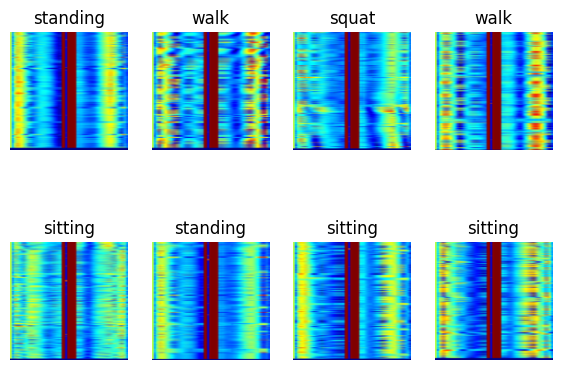

In [ ]:
# Path to dataset folder containing subfolders

IMG_SIZE = (128, 128)  # Resize images to a consistent shape

# Map class names to indices
class_names = ['walk', 'standing', 'squat', 'sitting', 'nothing']
class_indices = {name: i for i, name in enumerate(class_names)}


# Load all images and labels
X, y = [], []
for class_name in class_names:
    folder = os.path.join(DATA_DIR, class_name)
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            image = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
            X.append(np.array(image))
            y.append(class_indices[class_name])


X = np.array(X)
y = np.array(y)
print(f"folder:{folder}")

# Split dataset
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print shape summary
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# Plot first few images
cols = 4
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X[random_index, :])
        true_label = class_names[y[random_index]]
        ax.set_title("{}".format(true_label))
plt.show()
